# Generalized Lotka Volterra: joint alternate estimation for inverse problem

*Hugo Gangloff$^1$, Nicolas Jouvin$^1$, Lorenzo Sala$^2$ - December 2025*

$^1$ Université Paris-Saclay, AgroParisTech, INRAE UMR MIA Paris-Saclay, France

$^2$ Université Paris-Saclay, INRAE, MaIAGE, 78350, Jouy-en-Josas, France 

<div class="alert alert-block alert-info">
<b>Abstract</b>: In this notebook we jointly estimate the equation solution with a PINN and the equation parameter $\theta$. We will also make use of available observations and we will also differentiate the dynamic loss with respect to the equation parameter $\theta$. A long version of this notebook where more methods are compared is available <a href="https://mia_jinns.gitlab.io/jinns/Notebooks/Tutorials/GLV_JointEstimation_Alternate/">here</a>.
</div>

**Outline**

1. [Mathematical background](#Mathematical-background)
2. [Code set-up](#Code-set-up)
3. [Joint alternate training](#Joint-alternate-training)
4. [Vanilla joint training](#Vanilla-joint-training)
5. [Comparison of the approaches](#Comparison-of-the-approaches)

## Mathematical background

On the time interval $I=[0, T]$, we consider a **Generalized Lotka Volterra** system with $N_s$ populations, $\forall t\in I$, where $x_i(t)$ denotes the abundance (biomass) of species $i$ at time $t$:

$$
\frac{dx_i(t)}{dt} = \mu_i x_i(t) + \sum_{j=1}^{N_s} a_{ij} x_i(t) x_j(t), 
\quad i = 1, \dots, N_s,
$$

where $\mu_i$ are the growth rates and $a_{ij}$ are the interactions terms. We also have some initial conditions $x_i(0) = x_{i,0} > 0$.

We will work with the GLV equation in logarithmic (for stability and positiveness) and vectorial form (for concision):

$$
\frac{du(t)}{dt} = \mu + A \exp(u(t)),
$$
where $u(t) = (\log x_1(t), \dots, \log x_{N_s}(t))^\top$, 
$\mu = (\mu_1, \dots, \mu_{N_s})^\top$, 
and $A = (a_{ij})_{1 \le i,j \le N_s}$. We denote the equation parameters as $\theta=\{\mu, A\}$.

We are working in the context of **inverse problem**, *i.e.* we have at our disposal **noisy observations of the solution** at some sampled times $\{t_j, u_j\}_{j=1}^{n_o}$ that we will use to estimate both the solution $u$ and the parameters $\theta$. We work the in the **PINN methodology**, we approximate the solution as a neural network $u_\nu : I \mapsto \mathbb{R}^{N_s}$, where $\nu$ are the weights and biases of the neural network that we need to estimate.


Therefore, we aim at solving:

$$
\hat{\nu},\hat{\theta}=\arg\min_{\nu,\theta} \mathcal{L}(\nu,\theta)
$$
with the loss:

$$
\begin{align*}
\mathcal{L}(\nu,\theta)&=\frac{1}{n_c} \sum_{i=1}^{n_c} \Vert \frac{du_\nu(t_i)}{dt} - \mu - A \exp(u_\nu(t_i))\Vert^2 + \Vert u_\nu(0) - u_0 \Vert_2^2\\
&+\frac{1}{n_o} \sum_{j=1}^{n_o} \Vert u_\nu(t_j) - u_j \Vert^2,
\end{align*}
$$

where $\{t_i\}_{i=1}^{i=n_c}$ is a set of randomly selected collocation points and $u_0=(\log x_{1, 0}, \dots, \log x_{N_s,0})$ is the vector of initial condition values.

More precisely, [Section 3](#Joint-alternate-training-(simple)) will consider a coordinate descent on the problem above, namely, an alternate optimization between $\nu$ and $\theta=\{\mu,A\}$ will be set up.

- The optimization scheme for step $n+1$ can then be written for [Section 3](#Joint-alternate-training-(simple)):

$$
\begin{align*}
        \{\mu,A\}^{[n+1]} & \leftarrow \arg\min_{\{\mu,A\}} \frac{1}{n_c} \sum_{i=1}^{n_c} \Vert \frac{du_{\nu^{[n]}}(t_i)}{dt} - \mu - A \exp(u_{\nu^{[n]}}(t_i))\Vert^2 \\
        \nu^{[n+1]} & \leftarrow \arg\min_{\nu} \mathcal{L}(\nu,\{\mu,A\}^{[n+1]}).
\end{align*}
$$

On the other hand, [Section 4](#Vanilla-joint-training) will perform a direct joint optimization on both set of parameters.

- The optimization problem can then be written for [Section 4](#Vanilla-joint-training):

$$
\hat{\nu},\hat{\theta} = \arg\min_{\nu,\theta} \mathcal{L}(\nu,\theta).
$$


**Initialization**: in all cases:

- $\theta$ is initialization to the $0$ of its vector space.

- $\nu$ parameters are first initialized with `equinox` default initialization for weight and biaises in linear layers. However a **pretraining on data only** is performed for all optimization problems, serving as a "warm-up" for the neural network. That is the joint optimizations all begin with a $\nu^{ini}$ such that:

$$
\nu^{ini} = \arg\min_{\nu} \frac{1}{n_o} \sum_{j=1}^{n_o} \Vert u_\nu(t_j) - u_j \Vert^2
$$

- we use projected gradient descent to enforce some constraints:
  - $\mu\in(\mathbb{R}^+)^{N_s}$
  - $A_{i,i}\in\mathbb{R}^-, \forall i\in\{1, N_s\}$

## Code set-up

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

### Imports

In [2]:
import jinns

Import other dependencies

In [3]:
import jax

import jax.numpy as jnp
import optax
import equinox as eqx
import matplotlib.pyplot as plt

figsize = (4, 4)
plt.rcParams["figure.figsize"] = figsize

In [4]:
key = jax.random.PRNGKey(0)

W1216 11:34:13.653650   34128 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.
W1216 11:34:13.657060   34027 cuda_executor.cc:1802] GPU interconnect information not available: INTERNAL: NVML doesn't support extracting fabric info or NVLink is not used by the device.


### Define the equation parameters

Time domain

In [5]:
tmin = 0
tmax = 1

Tmax = 200

In [6]:
# initial conditions for each species

### Ns population example, stationary case
key, subkey = jax.random.split(key)

Ns = 4
A = jax.random.normal(subkey, shape=(Ns, Ns)) * 1e-2
key, subkey = jax.random.split(key)
dA = jnp.diag(A)
key, subkey = jax.random.split(key)
A *= jax.random.bernoulli(subkey, p=0.4, shape=A.shape)
A = A - A.T
A = A + jnp.diag(-jnp.abs(dA))
interactions = A
key, subkey = jax.random.split(key)
growth_rates = jnp.abs(jax.random.normal(subkey, shape=(Ns,))) * 1e-1
key, subkey = jax.random.split(key)
N_0 = jax.random.uniform(subkey, shape=(Ns,)) * 10

In [7]:
key, subkey = jax.random.split(key, 2)
val_data = jinns.data.DataGeneratorODE(
    key=subkey,
    nt=500,
    tmin=tmin,
    tmax=tmax,
    method="uniform",
    temporal_batch_size=None,
)

ts = val_data.times.sort(axis=0).squeeze()

### Observations

We use observations obtained from a run of a ground truth solver/

In [8]:
import numpy as np
from scipy.integrate import solve_ivp


def GLV_RHS(t, y, theta):
    """
    This equation is written in log space. That means the input y is the logarithm of the population density
    """
    alpha, gamma = theta[0], theta[1]
    return (alpha + (gamma @ jnp.exp(y).reshape((gamma.shape[0], 1))).squeeze()).ravel()


# Define model parameters
eq_params = (growth_rates, interactions)

# Define initial bacterial populations
y0 = N_0

# Define time points
t = ts * Tmax

############################

y0_log = np.log(y0)
sol_log = solve_ivp(
    fun=GLV_RHS,
    y0=y0_log,
    t_span=(0, Tmax),
    t_eval=ts * Tmax,
    args=(eq_params,),
)
y = np.exp(sol_log.y).T

In [9]:
n = 500
subsample_size = 10
subsample = jnp.arange(n)
subsample = subsample[:: int(n / (subsample_size - 1))]
subsample = jnp.append(subsample[:-1], n - 1)


t_subsample = ts[subsample]
log_obs_subsample = jnp.log(y[subsample])

__We then add a Gaussian noise (in log-space)__

The noise model is $\log y_i = \log y^\star(t_i) + \epsilon_i$ with Gaussian noise of variance $\sigma^2$. 

In [10]:
noise_level = 0.2

key, subkey = jax.random.split(key)
noise = noise_level * jax.random.normal(subkey, shape=log_obs_subsample.shape)
log_obs_subsample_noisy = log_obs_subsample + noise
# obs_subsample_noisy = jnp.where(obs_subsample_noisy < 1e-6, 1e-6, obs_subsample_noisy)

**Visualize the noisy observations**

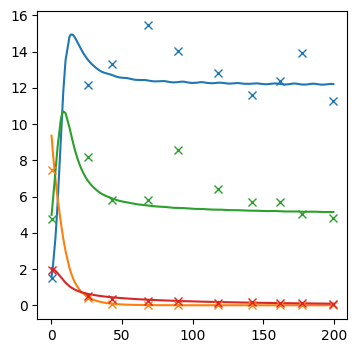

In [11]:
plt.plot(ts * Tmax, y, "-")
plt.gca().set_prop_cycle(None)
plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), "x")
plt.show()

### Estimate the solution and the parameters of the GLV system

*Define the domain and the associated data generator*

In [12]:
key, subkey = jax.random.split(key)
train_data = jinns.data.DataGeneratorODE(
    key=subkey,
    nt=1000,
    tmin=tmin,
    tmax=tmax,
    temporal_batch_size=None,
    method="uniform",
)

*Define the data generator for the observations*

In [13]:
key, subkey = jax.random.split(key)
obs_data = jinns.data.DataGeneratorObservations(
    key=subkey,
    obs_batch_size=None,
    observed_pinn_in=t_subsample,
    observed_values=log_obs_subsample_noisy,
)

*Define the PINN*

Create the neural network architecture for the PINN with `equinox`.

In [14]:
N_neurons = 7 * Ns
eqx_list = (
    (eqx.nn.Linear, 1, Ns),
    (jax.nn.tanh,),
    (eqx.nn.Linear, Ns, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, N_neurons),
    (jax.nn.tanh,),
    (eqx.nn.Linear, N_neurons, Ns),
    (jax.nn.tanh,),
    (eqx.nn.Linear, Ns, Ns),
)
key, subkey = jax.random.split(key)
u, init_nn_params = jinns.nn.PINN_MLP.create(
    key=subkey, eqx_list=eqx_list, eq_type="ODE"
)

*Define the jinns parameter object. **Equation parameters are initialized to 0 everywhere.***

In [15]:
init_params = jinns.parameters.Params(
    nn_params=init_nn_params,
    eq_params={
        "g": jnp.zeros_like(growth_rates),
        "i": jnp.zeros_like(interactions),
    },
)

*Define the loss weights*

In [16]:
loss_weights = jinns.loss.LossWeightsODE(
    dyn_loss=1.0 / Tmax, initial_condition=1.0, observations=1.0
)

*Define the dynamic loss term*

In [17]:
class GLV_loss(jinns.loss.ODE):
    def equation(self, t, u, params):
        """
        This equation is given in log, this means that u is the log of the population density
        """
        udt = jax.jacfwd(lambda x: u(x, params))(t).squeeze()
        f = udt - self.Tmax * GLV_RHS(
            t, u(t, params), (params.eq_params.g, params.eq_params.i)
        )
        return f


dynamic_loss = GLV_loss(Tmax=Tmax)

*Define how to differentiate each term of the loss* Note that the main `params` of the problem must be passed since we use the `from_str()` constructor

In [18]:
derivative_keys = jinns.parameters.DerivativeKeysODE.from_str(
    dyn_loss=jinns.parameters.Params(
        nn_params=True,
        eq_params={
            "g": jax.tree.map(lambda _: True, init_params.eq_params.g),
            "i": jax.tree.map(lambda _: True, init_params.eq_params.i),
        },
    ),
    initial_condition="nn_params",
    observations="nn_params",
    params=init_params,
)

*Define the ODE PINN losses*

In [19]:
loss = jinns.loss.LossODE(
    u=u,
    loss_weights=loss_weights,
    dynamic_loss=dynamic_loss,
    initial_condition=(float(tmin), jnp.log(y0)),
    derivative_keys=derivative_keys,
    params=init_params,
)

*We will start with a PINN pretraining on observations only. One argument in favor of such pretraining is  to avoid $\theta$ collapsing to $0$. All approaches that will follow will benefit from this pretraining.*

**Pretraining**

In [20]:
pretrain_loss_weights = jinns.loss.LossWeightsODE(
    dyn_loss=0.0,
    initial_condition=1.0,
    observations=1.0,  # ZERO to block gradients from dynamic loss
)
pretrain_loss = jinns.loss.LossODE(
    u=u,
    loss_weights=pretrain_loss_weights,
    dynamic_loss=dynamic_loss,
    initial_condition=(float(tmin), jnp.log(y0)),
    derivative_keys=derivative_keys,
    params=init_params,
)

In [21]:
pretrain_tx = optax.adam(learning_rate=1e-3)

key, subkey = jax.random.split(key)
print("PINN pretraining with observations only")
(
    pretrain_params,
    total_loss_values,
    loss_by_term_dict,
    _,
    _,
    _,
    _,
    stored_loss_weight_terms,
    _,
    _,
    _,
    _,
) = jinns.solve(
    n_iter=10000,
    init_params=init_params,
    data=train_data,
    optimizer=pretrain_tx,
    loss=pretrain_loss,
    obs_data=obs_data,
    print_loss_every=1000,
    key=subkey,
)

PINN pretraining with observations only
Initialization time: 0.5076131820678711

Compilation took
 5.548243284225464 

[train] Iteration 0: loss value = 110.10687255859375
[train] Iteration 1000: loss value = 29.48825454711914
[train] Iteration 2000: loss value = 10.624312400817871
[train] Iteration 3000: loss value = 3.679948568344116
[train] Iteration 4000: loss value = 1.2595371007919312
[train] Iteration 5000: loss value = 0.44472628831863403
[train] Iteration 6000: loss value = 0.1414739042520523
[train] Iteration 7000: loss value = 0.05033271387219429
[train] Iteration 8000: loss value = 0.038961030542850494
[train] Iteration 9000: loss value = 0.0371907502412796

Stopping main optimization loop, cause: max iteration is reached

Training took
 10.861737728118896 


Final iteration 10000: train loss value = 0.036809042096138


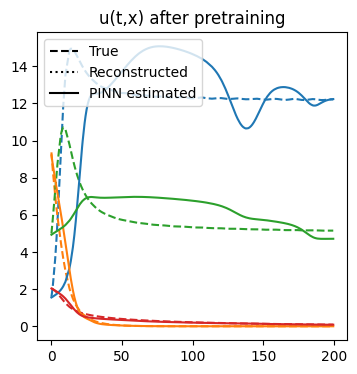

In [22]:
from matplotlib.lines import Line2D

pretrain_u_est = jax.vmap(lambda t_x: jnp.exp(u(t_x, pretrain_params)))

plt.plot(ts * Tmax, y, linestyle="--", label="True")
plt.gca().set_prop_cycle(None)
plt.plot(ts * Tmax, pretrain_u_est(ts), label="PINN estimated")
# plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), 'x')
plt.title("u(t,x) after pretraining")
legend_elements = [
    Line2D([0], [0], color="k", linestyle="--", label="True"),
    Line2D([0], [0], color="k", linestyle="dotted", label="Reconstructed"),
    Line2D([0], [0], color="k", label="PINN estimated"),
]
# Create the figure
plt.legend(handles=legend_elements, loc="upper left")
plt.show()

In [23]:
assert jnp.allclose(
    total_loss_values,
    loss_by_term_dict.observations * pretrain_loss_weights.observations
    + loss_by_term_dict.initial_condition * pretrain_loss_weights.initial_condition,
)  # check that we only use observations and initial conditions

The next cell defines the number of iterations and is common to both methods, with a slight adaptation for the non alternate method

In [24]:
# number of alternate iterations
n_iter = 250
# number of iterations for each solver
n_iter_by_solver = jinns.parameters.Params(
    nn_params=250,
    eq_params={"g": 250, "i": 250},
)

The next cell defines an optax update step that incorporates a projection of the parameters as described mathematically in the first section.

In [25]:
from typing import NamedTuple


def proj_g(p_eq_params_g):
    """ """
    p_0 = jnp.maximum(0, p_eq_params_g)

    return p_0


def proj_i(p_eq_params_i):
    """ """
    p_1 = jnp.fill_diagonal(
        p_eq_params_i, jnp.minimum(0, jnp.diag(p_eq_params_i)), inplace=False
    )

    return p_1


class EmptyState(NamedTuple):
    pass


def update_and_project(param: str) -> optax._src.base.GradientTransformation:
    """
    An optax GradientTransformation which updates the parameters and project them
    to enforce some constraints on the parameters
    """

    def init_fn(params: optax._src.base.Params) -> EmptyState:
        return EmptyState()

    def update_fn(grads, state, params=None):
        grads_ = grads

        grads = getattr(grads.eq_params, param)
        params = getattr(params.eq_params, param)

        # 1) Update
        new_params = jax.tree.map(
            lambda u, v: v + u, params, grads
        )  # grads = previous updates that have not been applied
        # hence the previous lines are equivalent to an optax.apply_updates

        if param == "g":
            next_x = proj_g(new_params)
        elif param == "i":
            next_x = proj_i(new_params)
        else:
            raise ValueError

        # 2) Project
        # We return prox_update - xold to be compatible with
        # with optax.apply_update(xold, additive_update) which is additive
        additive_update_ = jax.tree.map(lambda u, v: v - u, params, next_x)

        additive_update = eqx.tree_at(
            lambda pt: (getattr(pt.eq_params, param),), grads_, (additive_update_,)
        )

        return additive_update, EmptyState()

    return optax._src.base.GradientTransformation(init_fn, update_fn)

### Joint alternate training

**with `jinns.solve_alternate()`**

*We will need to construct the object needed for the `jinns.solve_alternate()` call.*

**Alternate joint estimation**

In [26]:
from functools import partial

update_and_project_g = partial(update_and_project, param="g")
update_and_project_i = partial(update_and_project, param="i")

In [27]:
start_learning_rate = 1e-3

# solver for each set of parameters
optimizers = jinns.parameters.Params(
    nn_params=optax.adamw(learning_rate=start_learning_rate),
    eq_params={
        "g": optax.chain(
            optax.adam(learning_rate=start_learning_rate),
            update_and_project_g(),
        ),
        "i": optax.chain(
            optax.adam(learning_rate=1e-6),
            update_and_project_i(),
        ),
    },
)

*We now start the alternate training*

In [28]:
(
    params_alternate,
    total_loss_values,
    loss_by_term_dict,
    _,
    _,
    _,
    stored_params,
    stored_loss_weight_terms,
    _,
    _,
) = jinns.solve_alternate(
    n_iter=n_iter,
    n_iter_by_solver=n_iter_by_solver,
    init_params=pretrain_params,
    data=train_data,
    loss=loss,  # take the complete loss!
    optimizers=optimizers,
    verbose=True,
    obs_data=obs_data,
    key=subkey,
    print_loss_every=20,
)

Initialization time: 7.493205547332764
[train alternate]Iteration 0: loss value = 1.6835134029388428
[train alternate]Iteration 20: loss value = 0.1537143886089325
[train alternate]Iteration 40: loss value = 0.06262316554784775
[train alternate]Iteration 60: loss value = 0.05100301280617714
[train alternate]Iteration 80: loss value = 0.048224855214357376
[train alternate]Iteration 100: loss value = 0.04730363190174103
[train alternate]Iteration 120: loss value = 0.04459017515182495
[train alternate]Iteration 140: loss value = 0.042866114526987076
[train alternate]Iteration 160: loss value = 0.040322329849004745
[train alternate]Iteration 180: loss value = 0.03936297446489334
[train alternate]Iteration 200: loss value = 0.03706550598144531
[train alternate]Iteration 220: loss value = 0.03467164933681488
[train alternate]Iteration 240: loss value = 0.032689861953258514

Stopping main optimization loop, cause: max iteration is reached

Final alternate iteration 250: loss value = 0.0322430

**Results**

*Plot the loss values*

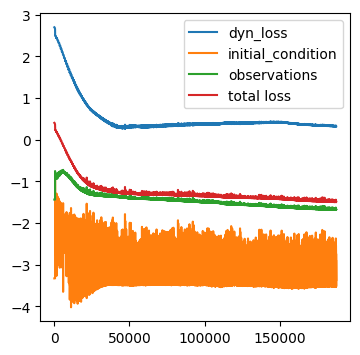

In [29]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_values), label="total loss")
plt.legend()
plt.show()

### Vanilla joint training

**with `jinns.solve()`**

**Loss for `jinns.solve()`**

In [30]:
loss = jinns.loss.LossODE(
    u=u,
    loss_weights=jinns.loss.LossWeightsODE(
        dyn_loss=1.0,
        initial_condition=1.0,
        observations=1.0,
    ),
    dynamic_loss=dynamic_loss,
    initial_condition=(float(tmin), jnp.log(y0)),
    derivative_keys=derivative_keys,
    params=init_params,
)

In [31]:
from functools import partial

update_and_project_g = partial(update_and_project, param="g")
update_and_project_i = partial(update_and_project, param="i")

param_labels = jinns.parameters.Params(
    nn_params="nn_adam",  # in this simple example we will use adamw for the nu
    eq_params={
        "g": "g_adam",
        "i": "i_adam",
    },  # in this simple example we will use rprop for theta
)

tx_nu_and_theta = optax.multi_transform(
    {
        "nn_adam": optax.adamw(learning_rate=1e-3),
        "g_adam": optax.chain(
            optax.adam(learning_rate=1e-3),
            update_and_project_g(),
        ),
        "i_adam": optax.chain(
            optax.adam(learning_rate=1e-6),
            update_and_project_i(),
        ),
    },  # all the keys in this dict must be found as leaves in the PyTree param_labels
    param_labels,
)

key, subkey = jax.random.split(key, 2)
n_iter_nu_and_theta = (n_iter * sum(jax.tree.leaves(n_iter_by_solver))) // (
    len(jax.tree.leaves(n_iter_by_solver))
)

In [32]:
params_vanilla, total_loss_values, loss_by_term_dict, _, _, _, _, _, _, _, _, _ = (
    jinns.solve(
        init_params=pretrain_params,
        data=train_data,
        optimizer=tx_nu_and_theta,
        loss=loss,
        n_iter=n_iter_nu_and_theta,
        obs_data=obs_data,
        print_loss_every=10000,
    )
)

Initialization time: 0.22481870651245117

Compilation took
 2.8864023685455322 

[train] Iteration 0: loss value = 498.12677001953125
[train] Iteration 10000: loss value = 0.45760276913642883
[train] Iteration 20000: loss value = 0.11770424991846085
[train] Iteration 30000: loss value = 0.10113035142421722
[train] Iteration 40000: loss value = 0.09056871384382248
[train] Iteration 50000: loss value = 0.08335909247398376
[train] Iteration 60000: loss value = 0.08043761551380157

Stopping main optimization loop, cause: max iteration is reached

Training took
 70.33206677436829 


Final iteration 62500: train loss value = 0.07960718125104904


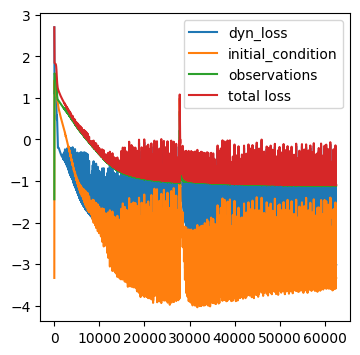

In [33]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_values), label="total loss")
plt.legend()
plt.show()

## Comparison of the approaches

### Error on parameters

In [34]:
from dataclasses import fields


def errors_on_parameters(true, estimated):
    return_dict = {}
    for f in fields(estimated.eq_params):
        p = getattr(estimated.eq_params, f.name)
        p_true = getattr(true, f.name)
        rmse = jnp.sqrt(jnp.mean((p - p_true) ** 2))
        return_dict[f.name] = rmse.item()
    return return_dict

In [35]:
from jinns.parameters import EqParams

true_params = EqParams({"g": growth_rates, "i": interactions})

rmse_parameters_alternate = errors_on_parameters(true_params, params_alternate)
rmse_parameters_vanilla = errors_on_parameters(true_params, params_vanilla)

In [36]:
import pandas as pd

df_error_parameters = pd.DataFrame.from_dict(
    {
        "Alternate": rmse_parameters_alternate,
        "Vanilla": rmse_parameters_vanilla,
    }
)

df_error_parameters.T

,g,i
Alternate,0.129912,0.016464
Vanilla,0.104650,0.008832


### Errors on the curves

In [37]:
def error_on_the_curves(y, pinn_estimated_function, params_estimated):
    """
    y: true curves
    """
    # Profiled error: RMSE error between the true curve and the PINN estimation
    rmse_p = jnp.sum(
        jax.vmap(lambda y, y_: jnp.mean((y - y_) ** 2), (1, 1))(
            y, pinn_estimated_function(ts)
        )
    )

    # Reconstructed error: RMSE error between the true curve and the ground truth solver solution run
    # with the system parameters estimated by jinns.solve_alternate()
    rec_sol_log = solve_ivp(
        fun=GLV_RHS,
        y0=y0_log,
        t_span=(0, Tmax),
        t_eval=ts * Tmax,
        args=(
            (
                params_estimated.eq_params.g,
                params_estimated.eq_params.i,
            ),
        ),
    )
    rec_y = np.exp(rec_sol_log.y).T
    rmse_r = jnp.sum(jax.vmap(lambda y, y_: jnp.mean((y - y_) ** 2), (1, 1))(y, rec_y))

    rmse_curves = {"profiled": rmse_p.item(), "reconstructed": rmse_r.item()}
    return rmse_curves, rec_sol_log

In [38]:
trained_u_est_alternate = jax.vmap(lambda t_x: jnp.exp(u(t_x, params_alternate)))

trained_u_est_vanilla = jax.vmap(lambda t_x: jnp.exp(u(t_x, params_vanilla)))


rmse_curves_alternate, rec_sol_log_alternate = error_on_the_curves(
    y, trained_u_est_alternate, params_alternate
)

rmse_curves_vanilla, rec_sol_log_vanilla = error_on_the_curves(
    y, trained_u_est_vanilla, params_vanilla
)

In [39]:
df_error_trajectories = pd.DataFrame.from_dict(
    {
        "Alternate": rmse_curves_alternate,
        "Vanilla": rmse_curves_vanilla,
    }
)

df_error_trajectories.T.rename(columns=lambda name: name.capitalize())

,Profiled,Reconstructed
Alternate,3.672025,3.171484
Vanilla,3.971438,3.900874


In [40]:
from matplotlib.lines import Line2D


def plot_curves(title, rec_sol_log, pinn_estimated_function):
    plt.plot(ts * Tmax, y)
    plt.gca().set_prop_cycle(None)
    if rec_sol_log.status == 0:
        rec_y = np.exp(rec_sol_log.y).T
        plt.plot(ts * Tmax, rec_y, linestyle="dotted", label="Reconstructed")
    else:
        print(
            "Warning! Curves from scipy solver with estimated parameters are not plotted because a problem appeared in the resolution"
        )
    plt.gca().set_prop_cycle(None)
    plt.plot(
        ts * Tmax, pinn_estimated_function(ts), linestyle="--", label="PINN estimated"
    )
    plt.gca().set_prop_cycle(None)
    plt.plot(t_subsample * Tmax, jnp.exp(log_obs_subsample_noisy), "x")
    plt.title(title)
    legend_elements = [
        Line2D([0], [0], color="k", label="True"),
        Line2D([0], [0], color="k", linestyle="dotted", label="Reconstructed"),
        Line2D([0], [0], color="k", linestyle="--", label="PINN estimated"),
        Line2D([0], [0], color="k", marker="x", linestyle="none", label="Observations"),
    ]
    # Create the figure
    plt.legend(handles=legend_elements, loc="upper left")
    plt.show()

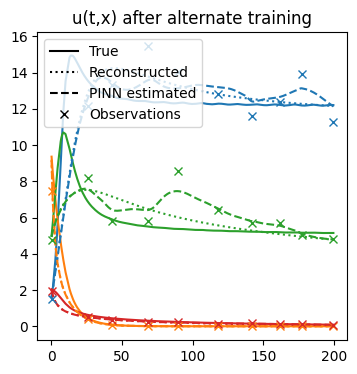

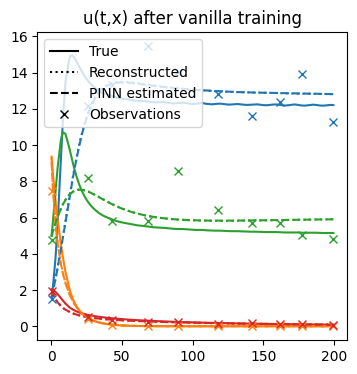

In [41]:
plot_curves(
    "u(t,x) after alternate training", rec_sol_log_alternate, trained_u_est_alternate
)
plot_curves("u(t,x) after vanilla training", rec_sol_log_vanilla, trained_u_est_vanilla)